In [8]:
%matplotlib inline

In [30]:
from qiskit_braket_provider import BraketProvider
provider = BraketProvider()
device = provider.get_backend("Aria 1")
print(device._get_gateset())

import matplotlib.pyplot as plt

plt.style.use('classic')
plt.rc("font", size=28)

{'h', 'rzz', 'sdg', 'rx', 'sx', 'cx', 'rxx', 's', 'ry', 'swap', 'tdg', 'sxdg', 't', 'ryy', 'z', 'rz', 'x', 'y'}


/home/liuyuhao/fermihedral/venv/lib/python3.10/site-packages/braket/aws/aws_device.py:662: UserWarning: AccessDeniedException: Unable to search region 'eu-west-2' for devices. Please check your settings or try again later. Continuing without devices in 'eu-west-2'.
  warnings.warn(


In [31]:
from dataclasses import dataclass
from fermihedral.fock import compile_molecule
from qiskit_nature.second_q.mappers import BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.second_q.mappers.fermionic_mapper import FermionicMapper
from qiskit.quantum_info import Pauli
from qiskit import transpile


class FermihedralMapper(FermionicMapper):
    SOLUTIONS = {
        8: [
            "_Z__Z_Z_",
            "Z___Z_X_",
            "___ZYY__",
            "____X__X",
            "_Y__Z_Z_",
            "____X__Z",
            "Y___Z_X_",
            "X___Z_X_",
            "_X__Z_Z_",
            "__Y_X__Y",
            "__Z_X__Y",
            "___ZYZ__",
            "___ZYX__",
            "____Z_Y_",
            "___YY___",
            "___XY___",
        ],
        6: [
            "Z__Y__",
            "Y____Y",
            "Y____Z",
            "Z__X__",
            "Z__Z__",
            "XZX___",
            "XYX___",
            "Y____X",
            "X_Y_Y_",
            "XXX___",
            "X_Z___",
            "X_Y_Z_",
        ],
        4: ["XZ_X", "YZ_X", "ZZZX", "_ZZY", "ZZX_", "Z_Y_", "ZXXZ", "ZYXZ"],
        2: ["YX", "XX", "_Z", "_Y"],
        12: [
            "____Y____Z__",
            "YY__X_______",
            "Z___X__Y____",
            "____YX___X__",
            "__ZZZ_______",
            "__X_Z_X_____",
            "YZ__X_______",
            "__Y_Z_____X_",
            "____YZ___X__",
            "__ZXZ_______",
            "X___X______Y",
            "X___X______X",
            "__Y_Z_____Z_",
            "YX__X_______",
            "____Y___YY__",
            "____Y___XY__",
            "____Y___ZY__",
            "____YY___X__",
            "__Y_Z_____Y_",
            "__X_Z_Y_____",
            "__X_Z_Z_____",
            "X___X______Z",
            "__ZYZ_______",
            "Z___X__X____",
        ],
        10: [
            "_____XY__X",
            "___X_XZ___",
            "_____XY__Y",
            "_____XY__Z",
            "_____XX_X_",
            "_____XX_Y_",
            "_____Z_Z__",
            "_____XX_Z_",
            "___Y_XZ___",
            "___Z_XZ___",
            "_X__XY____",
            "_ZY__Y____",
            "YY___Y____",
            "ZY___Y____",
            "_ZX__Y____",
            "_ZZ__Y____",
            "_____Z_X__",
            "_____Z_Y__",
            "_X__YY____",
            "XY___Y____",
        ],
    }

    @classmethod
    def get_solution(cls, nmodes: int):
        assert (
            nmodes in cls.SOLUTIONS
        ), f"undefined fermion-to-qubit mapping of {nmodes} modes"

        return [string.replace("_", "I") for string in cls.SOLUTIONS[nmodes]]

    @classmethod
    def pauli_table(
        cls, register_length: int, *, _: int | None = None
    ) -> list[tuple[Pauli, Pauli]]:
        solution = cls.get_solution(register_length)

        tables = []
        for j in range(register_length):
            tables.append((Pauli(solution[2 * j]), Pauli(solution[2 * j + 1])))

        return tables


bk = BravyiKitaevMapper()
fh = FermihedralMapper()
jw = JordanWignerMapper()


@dataclass
class SimulationData:
    error_q2: list[float]
    actual: list[float]
    estimate: list[float]
    variance: list[float]


exp_result = {
    "BK": SimulationData([], [], [], []),
    "JW": SimulationData([], [], [], []),
    "Our Method": SimulationData([], [], [], []),
}

def remove_reset(circuit):


    for index, instruction in enumerate(circuit):
        if instruction.operation.name == "reset":
            del circuit.data[index]
            remove_reset(circuit)
            break

def run_on_amazon(circuit, shots):
    circuit = transpile(circuit, basis_gates=["u3", "cx"], optimization_level=3)
    remove_reset(circuit)
    task = device.run(circuit, shots=shots)
    arn = task.job_id()
    print(arn)

for mapper, name in [(fh, "Our Method"), (bk, "BK"), (jw, "JW")]:
    circuit, observable, initial_energy = compile_molecule(
        "H 0 0 0; H 0 0 0.735", mapper, 0, remove_orbits=None
    )

    result = run_on_amazon(circuit, 3000)

/home/liuyuhao/fermihedral/venv/lib/python3.10/site-packages/qiskit_braket_provider/providers/adapter.py:481: UserWarning: Device does not support global phase; global phase of 4.344839715825843 will not be included in Braket circuit
  warnings.warn(


arn:aws:braket:us-east-1:849837135378:quantum-task/acac68fe-fb7b-426e-a384-a03c2ac7447b


/home/liuyuhao/fermihedral/venv/lib/python3.10/site-packages/qiskit_braket_provider/providers/adapter.py:481: UserWarning: Device does not support global phase; global phase of 5.71928650177138 will not be included in Braket circuit
  warnings.warn(


arn:aws:braket:us-east-1:849837135378:quantum-task/28562416-420f-4f5a-a6ab-ae2f2535ab1d
JordanWignerMapper_H 0 0 0; H 0 0 0.735_0 not found solved result
> solved H 0 0 0; H 0 0 0.735, 0 state, JordanWignerMapper, E = -1.8572750302023797


/home/liuyuhao/fermihedral/venv/lib/python3.10/site-packages/qiskit_braket_provider/providers/adapter.py:481: UserWarning: Device does not support global phase; global phase of 2.9703929298803082 will not be included in Braket circuit
  warnings.warn(


arn:aws:braket:us-east-1:849837135378:quantum-task/bb233672-6538-4199-8526-f58376f542f7


<Figure size 640x480 with 0 Axes>

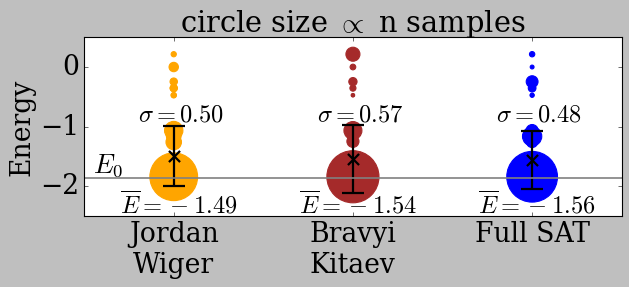

In [29]:
from qiskit.quantum_info import Statevector
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.second_q.mappers.fermionic_mapper import FermionicMapper
from math import sqrt
from qiskit.quantum_info import Pauli
from statistics import mean, variance
import numpy as np

import matplotlib.pyplot as plt

plt.style.use("classic")
plt.rc("font", size=24, family="serif")

BASELINE = -1.8572750302023797

JORDAN_WIGNER = {"0000": 0.023666666666666666,
                 "1000": 0.02,
                 "0100": 0.008,
                 "1100": 0.007333333333333333,
                 "0010": 0.06466666666666666,
                 "1010": 0.615,
                 "0110": 0.04466666666666667,
                 "1110": 0.04033333333333333,
                 "0001": 0.006333333333333333,
                 "1001": 0.04633333333333333,
                 "0101": 0.014666666666666666,
                 "1101": 0.014333333333333333,
                 "0011": 0.017,
                 "1011": 0.057,
                 "0111": 0.013333333333333334,
                 "1111": 0.007333333333333333}

BRAVYI_KITAEV = {"0000": 0.008666666666666666,
                 "1000": 0.010666666666666666,
                 "0100": 0.018333333333333333,
                 "1100": 0.03833333333333333,
                 "0010": 0.028666666666666667,
                 "1010": 0.053,
                 "0110": 0.049,
                 "1110": 0.7333333333333333,
                 "0001": 0.0033333333333333335,
                 "1001": 0.0003333333333333333,
                 "0101": 0.0023333333333333335,
                 "1101": 0.010333333333333333,
                 "0011": 0.005333333333333333,
                 "1011": 0.002,
                 "0111": 0.01,
                 "1111": 0.026333333333333334}

FERMIHEDRAL = {"0000": 0.004,
               "1000": 0.0033333333333333335,
               "0100": 0.01633333333333333,
               "1100": 0.024,
               "0010": 0.002,
               "1010": 0.008,
               "0110": 0.004666666666666667,
               "1110": 0.03766666666666667,
               "0001": 0.028666666666666667,
               "1001": 0.033,
               "0101": 0.10033333333333333,
               "1101": 0.6943333333333334,
               "0011": 0.007666666666666666,
               "1011": 0.004666666666666667,
               "0111": 0.016,
               "1111": 0.015333333333333332}


class FermihedralMapper(FermionicMapper):
    SOLUTIONS = {8: ['_Z__Z_Z_', 'Z___Z_X_', '___ZYY__', '____X__X', '_Y__Z_Z_', '____X__Z', 'Y___Z_X_', 'X___Z_X_', '_X__Z_Z_', '__Y_X__Y', '__Z_X__Y', '___ZYZ__', '___ZYX__', '____Z_Y_', '___YY___', '___XY___'],
                 6: ['Z__Y__', 'Y____Y', 'Y____Z', 'Z__X__', 'Z__Z__', 'XZX___', 'XYX___', 'Y____X', 'X_Y_Y_', 'XXX___', 'X_Z___', 'X_Y_Z_'],
                 4: ['XZ_X', 'YZ_X', 'ZZZX', '_ZZY', 'ZZX_', 'Z_Y_', 'ZXXZ', 'ZYXZ'],
                 2: ['YX', 'XX', '_Z', '_Y'],
                 12: ['____Y____Z__', 'YY__X_______', 'Z___X__Y____', '____YX___X__', '__ZZZ_______', '__X_Z_X_____', 'YZ__X_______', '__Y_Z_____X_', '____YZ___X__', '__ZXZ_______', 'X___X______Y', 'X___X______X', '__Y_Z_____Z_', 'YX__X_______', '____Y___YY__', '____Y___XY__', '____Y___ZY__', '____YY___X__', '__Y_Z_____Y_', '__X_Z_Y_____', '__X_Z_Z_____', 'X___X______Z', '__ZYZ_______', 'Z___X__X____'],
                 10: ['_____XY__X', '___X_XZ___', '_____XY__Y', '_____XY__Z', '_____XX_X_', '_____XX_Y_', '_____Z_Z__', '_____XX_Z_', '___Y_XZ___', '___Z_XZ___', '_X__XY____', '_ZY__Y____', 'YY___Y____', 'ZY___Y____', '_ZX__Y____', '_ZZ__Y____', '_____Z_X__', '_____Z_Y__', '_X__YY____', 'XY___Y____']}

    @classmethod
    def get_solution(cls, nmodes: int):
        assert nmodes in cls.SOLUTIONS, f"undefined fermion-to-qubit mapping of {nmodes} modes"

        return [string.replace("_", "I") for string in cls.SOLUTIONS[nmodes]]

    @classmethod
    def pauli_table(
        cls, register_length: int, *, _: int | None = None
    ) -> list[tuple[Pauli, Pauli]]:
        solution = cls.get_solution(register_length)

        tables = []
        for j in range(register_length):
            tables.append((Pauli(solution[2 * j]), Pauli(solution[2 * j + 1])))

        return tables


def process(data: dict[str, float], mapper: FermionicMapper):
    problem = PySCFDriver("H 0 0 0; H 0 0 0.735").run()

    hamiltonian = mapper.map(problem.hamiltonian.second_q_op())

    energies = []

    for state, prob in data.items():
        initial_state = Statevector.from_label(state[::-1])
        exp_energy = initial_state.expectation_value(hamiltonian)

        n = round(prob * 3000)

        for _ in range(n):
            energies.append(exp_energy.real)

    return mean(energies), sqrt(variance(energies)), np.unique(energies, return_counts=True)


plt.clf()
plt.figure(figsize=(8, 3.5))
plt.subplots_adjust(left=0.13, right=0.97, top=0.88, bottom=0.24)

# Jordan-Wigner


def plot(data, mapper, id):
    COLOR = ["orange", "brown", "blue"][id - 1]

    exp, var, (samples, counts) = process(data, mapper)
    plt.scatter([id] * len(samples), samples, s=counts, color=COLOR)
    plt.scatter([id], [exp], s=[100], marker="x",
                color="black", linewidths=2)
    plt.errorbar([id], [exp], [var], color="black",
                 elinewidth=2, capsize=10, capthick=2)
    plt.annotate(f"$\sigma={var:.2f}$", (id - 0.2, -0.9), fontsize=22)
    plt.annotate(f"$\overline{{E}}={exp:.2f}$", (id - 0.3, -2.45), fontsize=22)


plot(JORDAN_WIGNER, JordanWignerMapper(), 1)
plot(BRAVYI_KITAEV, BravyiKitaevMapper(), 2)
plot(FERMIHEDRAL, FermihedralMapper(), 3)

plt.plot([0, 1, 2, 3, 4], [BASELINE, BASELINE,
         BASELINE, BASELINE, BASELINE], color="gray", linewidth=1.5)
plt.annotate("$E_0$", (0.55, BASELINE + 0.1))

plt.xlim(0.5, 3.5)
plt.xticks([1, 2, 3], ["Jordan\nWiger", "Bravyi\nKitaev", "Full SAT"])
plt.title("circle size $\propto$ n samples", fontsize=26)
plt.ylabel("Energy")
plt.yticks([-2.0, -1.0,  0])
plt.savefig("ionq-H2.pdf")
